<a href="https://colab.research.google.com/github/123453ANSH/fMRIAnalysis/blob/main/Neurotech_NMEP_lesson_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Lesson 2: Single Voxel Modeling**

This lesson outlines an end to end simulation for analyzing a single voxel FMRI signal and utilizing simple regression models to classify activation. We will cover:
* Voxel Time Series Simulation
* Parameter Matrix Design
* Applying Least Squares

General Linear Models (GLM) support simple machine learning algorithms that heavily rely on linearized mathematics to find approximations in a system. For the FMRI module we will focus on these techniques and later will introduce more complex machine learning models.

In [1]:
# Imports
!pip install nltools

%matplotlib inline

import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nltools.stats import regress
from nltools.external import glover_hrf

     |████████████████████████████████| 3.4MB 5.5MB/s 
     |████████████████████████████████| 2.5MB 37.7MB/s 


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.linear_model.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.linear_model. Anything that cannot be imported from sklearn.linear_model is now part of the private API.
  warnings.warn(message, FutureWarning)


## **Time Series Simulation**

Before trying to create a model for us to regress over different voxels in an FMRI dataset, lets create a simulation to help us better visualize what our model will be looking for. We will use the **Musical Stimuli Depression** discussed in the previous section as the example.

Every dataset will have a series of events and different stimuli that occur at different times within an expirement. Looking closer into the dataset we see that the **positive stimuli** events and **negative stimuli** events occur at particular intervals within the time series sample. Using this experimental design information we can create a series of peaks that align with the events.

Reading the paper we can extract important sampling parameters and 1 of these is the **TR** or the time between each FMRI sample (temporal resolution). The **TR** for this study is : 3000 msec = 3 seconds.

We will also vary the **intensity** of each simulated event as realistically, a single voxel will contribute differently to a certain signal response. In this case lets assume that the negative music signal is weaker for the voxel we are simulating.

![image](https://www.ncbi.nlm.nih.gov/corecgi/tileshop/tileshop.fcgi?p=PMC3&id=158570&s=61&r=1&c=1)


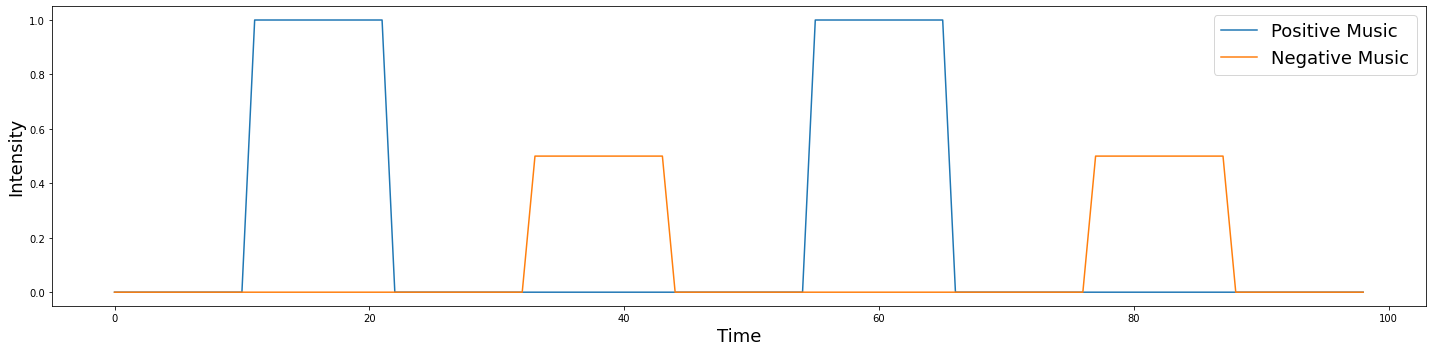

In [ ]:

tr = 3 # TR
study_dur = 33 * 9 # Study Duration From Above (Seconds)
event_dur = 33 # Event Duration (Seconds)
n_tr = int(study_dur / tr) # Number of Samples
event_tr = int(event_dur / tr) # Samples per Event

# Positive Music Events
pos_mus = np.zeros(n_tr)
pos_mus_intensity = 1
# Peak 1
pos_mus[np.arange(event_tr, event_tr * 2)] = pos_mus_intensity
pos_mus[np.arange(event_tr * 5, event_tr * 6)] = pos_mus_intensity


# Negative Music Events
neg_mus = np.zeros(n_tr)
neg_mus_intensity = 0.5
neg_mus[np.arange(event_tr * 3, event_tr * 4)] = neg_mus_intensity
neg_mus[np.arange(event_tr * 7, event_tr * 8)] = neg_mus_intensity

# Create Matrix
voxel = np.vstack([pos_mus, neg_mus]).T

plt.figure(figsize=(20,5))
plt.plot(voxel)
plt.legend(['Positive Music', 'Negative Music'], fontsize=18)
plt.ylabel('Intensity', fontsize=18)
plt.xlabel('Time', fontsize=18)
plt.tight_layout()

Each of these peaks align with a specific time point within the simulated study and the time of introduction for that specific stimuli. We now use the convolution technique introduced earlier to simulate the delayed HRF response and stimuli duration. The oversampling parameter here is important as it determines how smooth we want our simulation to be. To match our event duration we will stick to **1 sample per TR**.

Text(0.5, 0, 'Time')

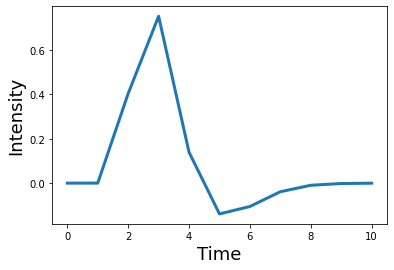

In [ ]:
# HRF Function
tr = 3 # TR
sampling = 1 # Samples Per TR
hrf = glover_hrf(tr, oversampling=sampling, time_length=event_dur)
plt.plot(hrf, linewidth=3)
plt.ylabel('Intensity', fontsize=18)
plt.xlabel('Time', fontsize=18)

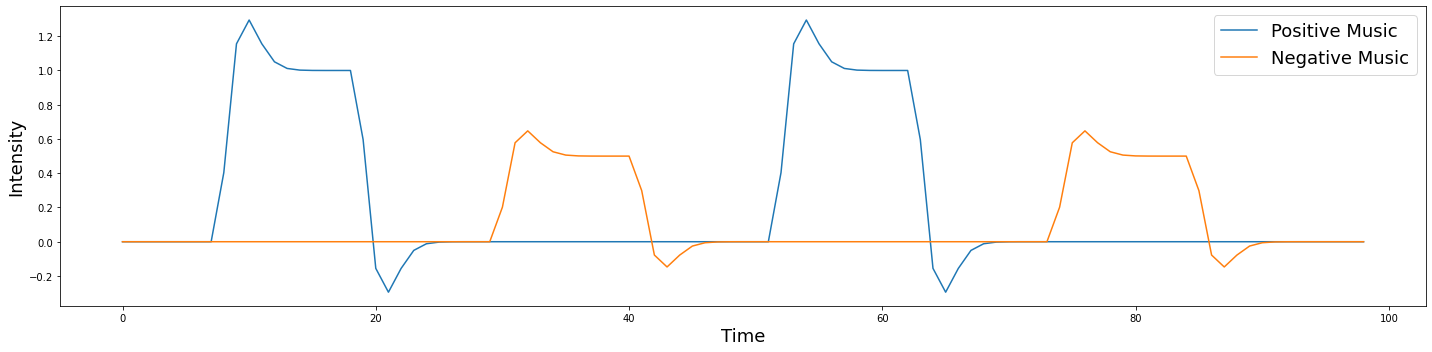

In [ ]:
# Convolve Signal
pos_conv = np.convolve(pos_mus, hrf, mode='same')
neg_conv = np.convolve(neg_mus, hrf, mode='same')
voxel_conv = np.vstack([pos_conv, neg_conv]).T

plt.figure(figsize=(20,5))
plt.plot(voxel_conv)
plt.legend(['Positive Music', 'Negative Music'], fontsize=18)
plt.ylabel('Intensity', fontsize=18)
plt.xlabel('Time', fontsize=18)
plt.tight_layout()

Finally, as we did before lets introduce some **random noise** that could represent a variety of different FMRI based artifacts that are present in FMRI time voxel signals. In real simulations, specific noise sources are simulated such as low freqency drifts, signal shifting or machine artifacts that are accounted for by being introduced into the simulation and, as we will see later, the model itself. We will introduce noise and sum the signals to generate our final simulated signal.

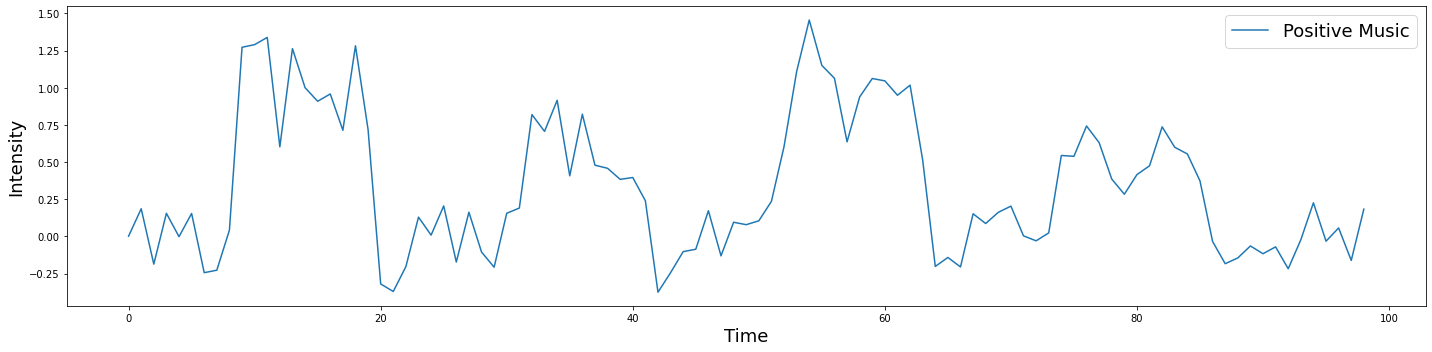

In [ ]:
# Normal Distribution Variance
sigma = 0.125
epsilon = sigma*np.random.randn(n_tr, 2)
voxel_conv_noise = voxel_conv + epsilon

# Sum
voxel_sum = voxel_conv_noise.sum(axis=1)

plt.figure(figsize=(20,5))
plt.plot(voxel_sum)
plt.legend(['Positive Music', 'Negative Music'], fontsize=18)
plt.ylabel('Intensity', fontsize=18)
plt.xlabel('Time', fontsize=18)
plt.tight_layout()

## **Design Matrix**
The simulated voxel series above represents an area in which the two events are active. To find these areas we need to design a system that allows us to check every voxel time series and figure out if it shows signs of firing due to the **positive music event** and/or the **negative music event**.

To figure this out we will use a common linear algebra technique called the **Least Square Algorithm** but before applying our algorithm we need to define a model of how the time series is generated from our stimuli vectors.

In general, for **General Linear Models** (GLM) the form is as follows:
\begin{align}
Y = X\vec{b} + \vec{e}
\end{align}
* **Y** represents the voxel time series we are trying to model and analyze
* **X** represents a **Design Matrix** which is collection of vector signals that correspond with the pattern of the stimuli we are trying to analyze.
* **b** represents a vector of **weights** that determine the intesity of each of the stimuli components within the signal we are trying to analyze. This **b** vector is the primary output of our Least Squares Analysis.
* **e** accounts for all other sources of information or noise that we are not intrested in.

The mathematics of this system are not extremely relevant for our scope but the basic concept is we represent every voxel time signal as a **weighted sum** of our **target stimuli signals** we simulated above. Based on the **weights** in **b** we extract we can make various conclusions about each voxel in a dataset and find voxels that **best match** the expected pattern.





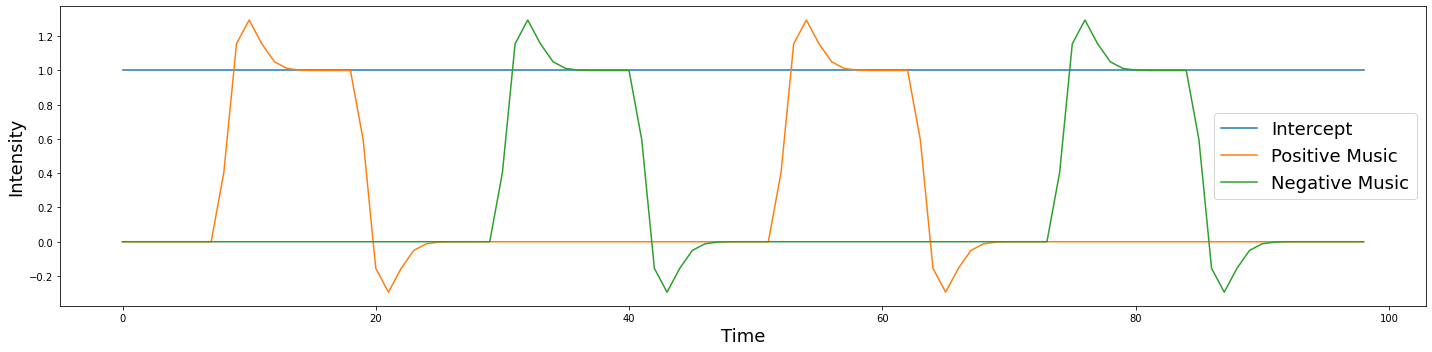

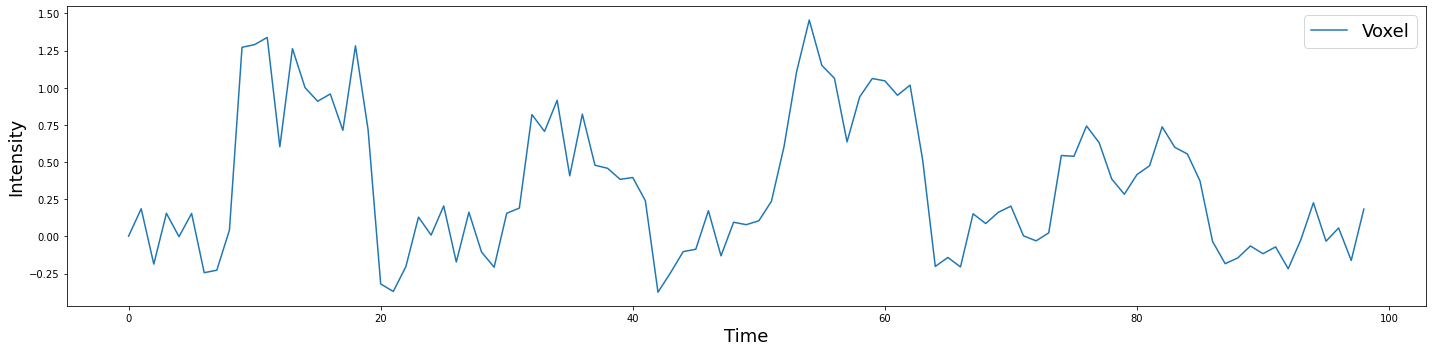

In [ ]:
# Design Matrix Vectors

# Positive Music Events
pos_des = np.zeros(n_tr)
pos_des[np.arange(event_tr, event_tr * 2)] = 1
pos_des[np.arange(event_tr * 5, event_tr * 6)] = 1


# Negative Music Events
neg_des = np.zeros(n_tr)
neg_des[np.arange(event_tr * 3, event_tr * 4)] = 1
neg_des[np.arange(event_tr * 7, event_tr * 8)] = 1

# Intercept
intercept = np.ones(n_tr)

# Create Matrix
design = np.vstack([intercept, np.convolve(pos_des, hrf, mode='same'), np.convolve(neg_des, hrf, mode='same')]).T

# Plot Matrix
plt.figure(figsize=(20,5))
plt.plot(design)
plt.legend(['Intercept', 'Positive Music', 'Negative Music'], fontsize=18)
plt.ylabel('Intensity', fontsize=18)
plt.xlabel('Time', fontsize=18)
plt.tight_layout()

# Plot Voxel (Simulation)
plt.figure(figsize=(20,5))
plt.plot(voxel_sum)
plt.legend(['Voxel'], fontsize=18)
plt.ylabel('Intensity', fontsize=18)
plt.xlabel('Time', fontsize=18)
plt.tight_layout()

To more clearly represent the above, we are asserting the following. We will run an algorithm to find all the **b** values in the following equation.

\begin{align}
Voxel = b_{0} * Intercept + b_{1} * Positive Music + b_{2} * Negative Music 
\end{align}

**Get this better**


## **Least Squares Algorithm**

The last part of this pipeline is estimating the **b** values of our model using our simulated voxel data. For this we will use **Least Squares** which is a simple algorithm that depends on basic linear algebra concepts such as matrix manipulation. Below is the algorithm using the definitions above and if you're intrested here's an EE16a resource on the [topic](https://eecs16a.org/lecture/Note23.pdf).

\begin{align}
\vec{b} = (X^TX)^{-1}X^TY
\end{align}


**Read in depth**


b_val Positive, b_val Negative: 0.9874901341552174 0.5208163443354199


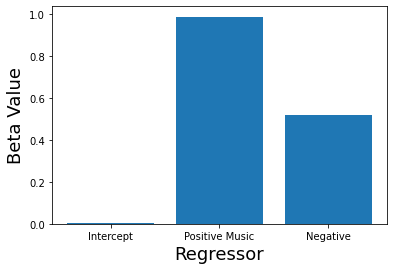

In [ ]:
X = design # Design Matrix Created Above
Y = voxel_sum # Simulated Voxel Data

def least_squares(X, Y):
    return np.dot(np.dot(np.linalg.pinv(np.dot(X.T, X)), X.T), Y)
# or use numpy.linalg.lstsq

b_vec = least_squares(X, Y)

plt.bar(['Intercept','Positive Music', 'Negative Music'], b_vec)
plt.xlabel('Regressor', fontsize=18)
plt.ylabel('Beta Value', fontsize=18)

print('b_val Positive, b_val Negative:', b_vec[1], b_vec[2])

From this estimate we can clearly see how the relative intensity of each of our signals is reflected within the beta values returned by **Least Squares**. We see that the **negative stimuli** intensity is half of the **positive stimuli** within the data we created.

Applying this to **real data**, we use a similar approach:
* Create a Design Matrix
* Filter or Pre-Process Voxel Data
* Estimate B_Vec for every Voxel Time Series Using Least Squares

The Voxels with the **highest** relative **b_vec** values are candidates of interest showing that these voxel areas might correspond with the event being studied.


**What does a higher voxel value mean? **